In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

from scipy.stats import percentileofscore
from scipy.spatial.distance import pdist

from joblib import Parallel, delayed

import matplotlib.pyplot as plt

plt.rcParamsDefault['figure.figsize'] = plt.rcParams['figure.figsize'] = 25, 10
pd.options.display.max_rows = 16
pd.options.display.precision = 3

# Data preparation

In [2]:
# Pick yours
df = pd.read_csv('/tmp/netztest-opendata_hours-048.csv')
df = pd.read_csv('/tmp/netztest-opendata.csv')

In [3]:
# Select subsets of relevant features

X = df[['sim_mcc_mnc',
        'network_type',
        'model']]

y = df[['ping_ms',
        'download_kbit',
        'upload_kbit']]

In [4]:
# Purge values known to be irrelevant
X = X[~X.model.isin(['Firefox', 'Mozilla', 'Chrome', 'IE'])]
X = X[~X.network_type.isin(['WLAN', 'LAN', 'Bluetooth', 'Ethernet'])]

# Purge X values with less than N appearances
for col in X.columns:
    counts = X[col].value_counts()
    valid = ~X[col].isin(counts[counts < 50].index)
    X = X[valid]

# Prune y percentile outliers
for col in y.columns:
    vals = y[col]
    y = y[vals.between(*vals.quantile((.02, .98)))]

# Only keep what is contained in both sets
keep = X.index & y.index
X = X.loc[keep]
y = y.loc[keep]

# Visualization

,sim_mcc_mnc,network_type,model
count,28737,28734,28738
unique,23,9,90
top,232-01,LTE,iPad mini 2G Cellular
freq,10734,23840,2803


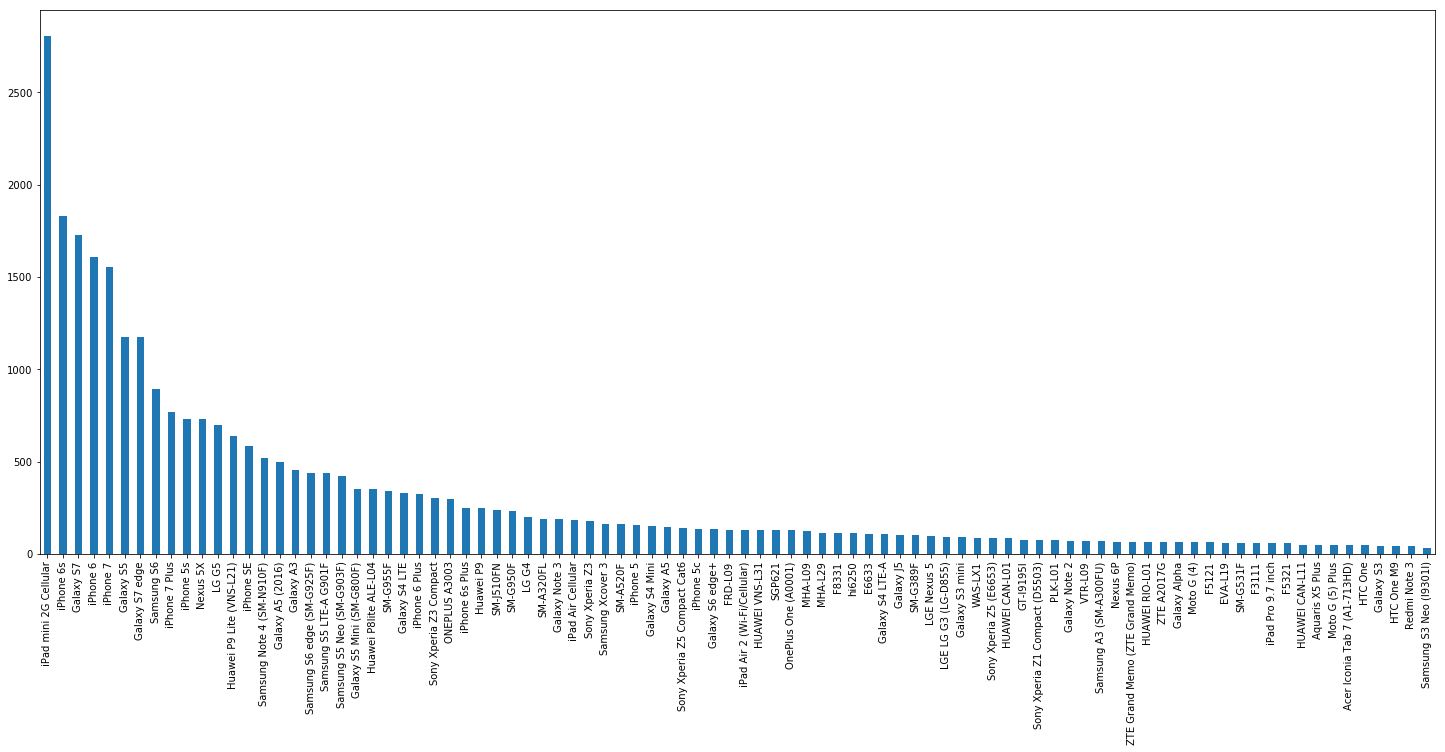

In [5]:
X.model.value_counts().plot.bar()
X.describe()

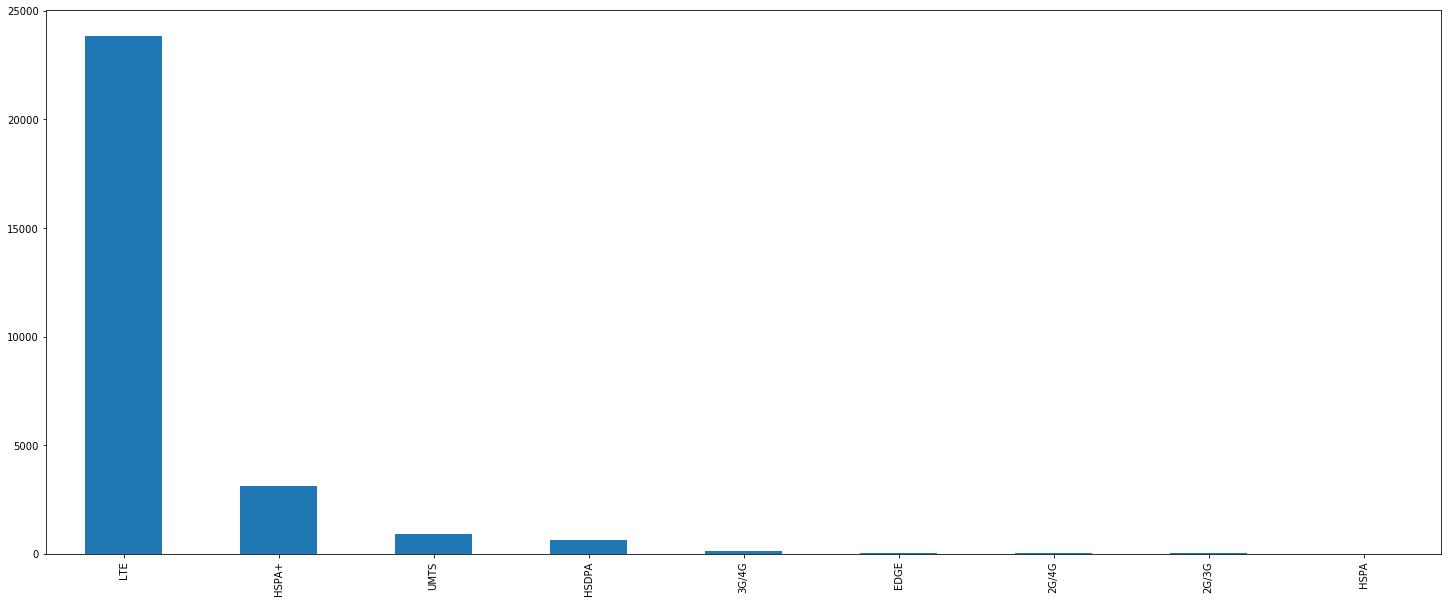

In [6]:
X.network_type.value_counts().plot.bar()

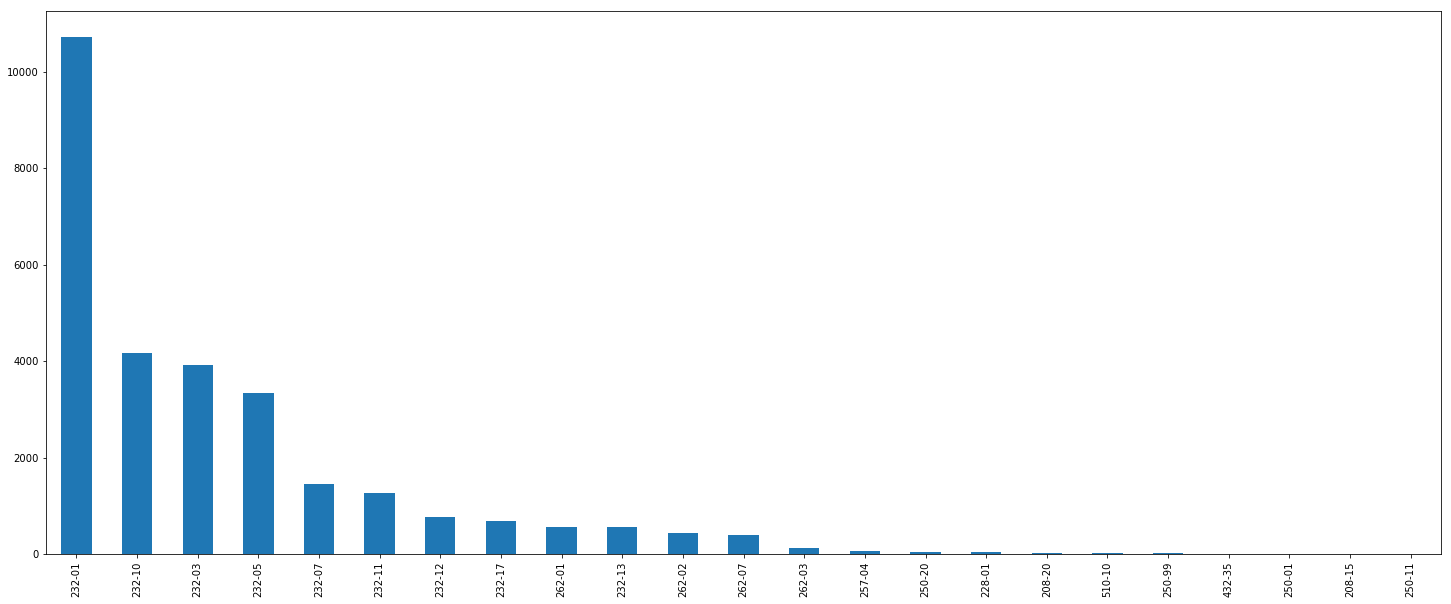

In [7]:
X.sim_mcc_mnc.value_counts().plot.bar()

,ping_ms,download_kbit,upload_kbit
count,28738.000,28738.000,28738.000
mean,35.314,29448.046,10827.965
std,19.163,22673.309,10560.993
min,8.500,325.000,166.000
25%,23.000,11548.000,2397.000
50%,30.000,23281.500,6694.000
75%,40.100,43037.500,17212.000
max,251.600,105379.000,39994.000


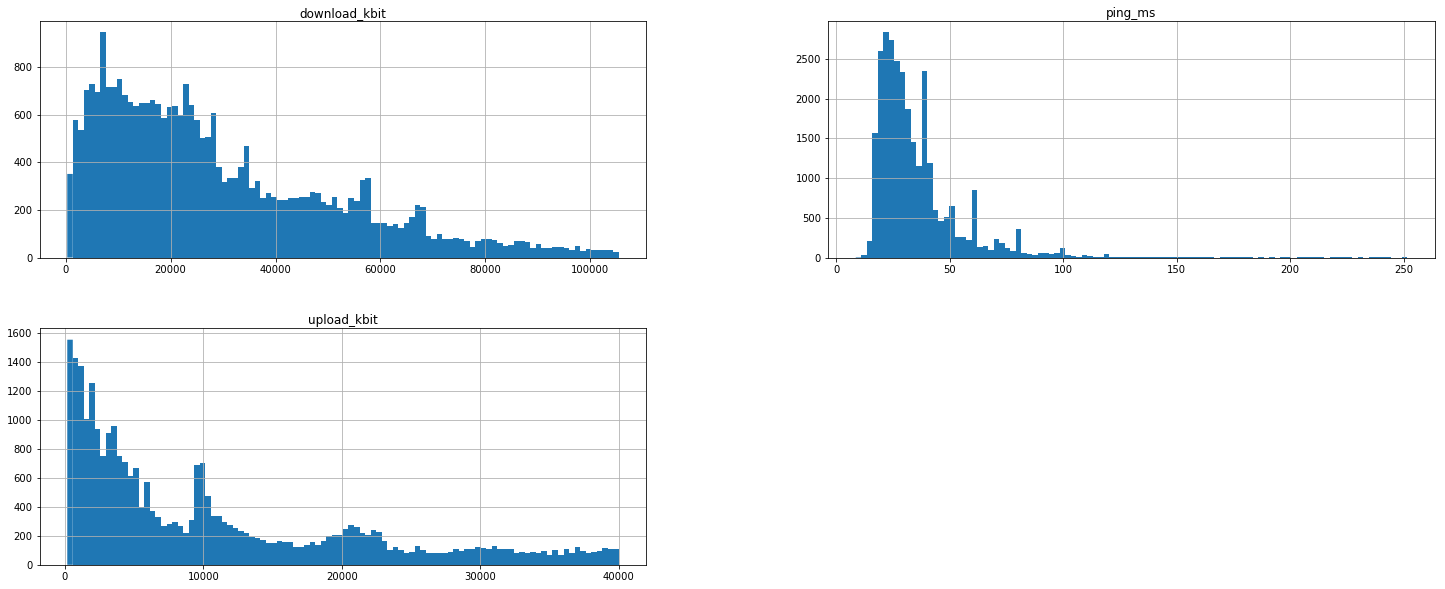

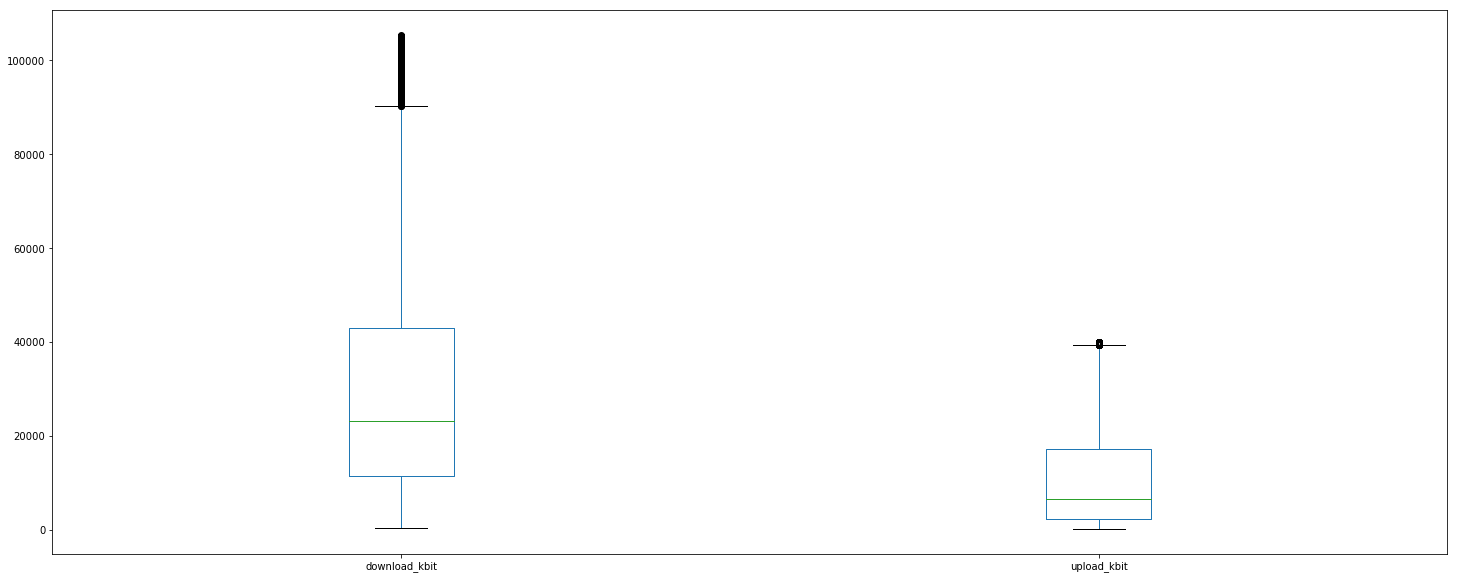

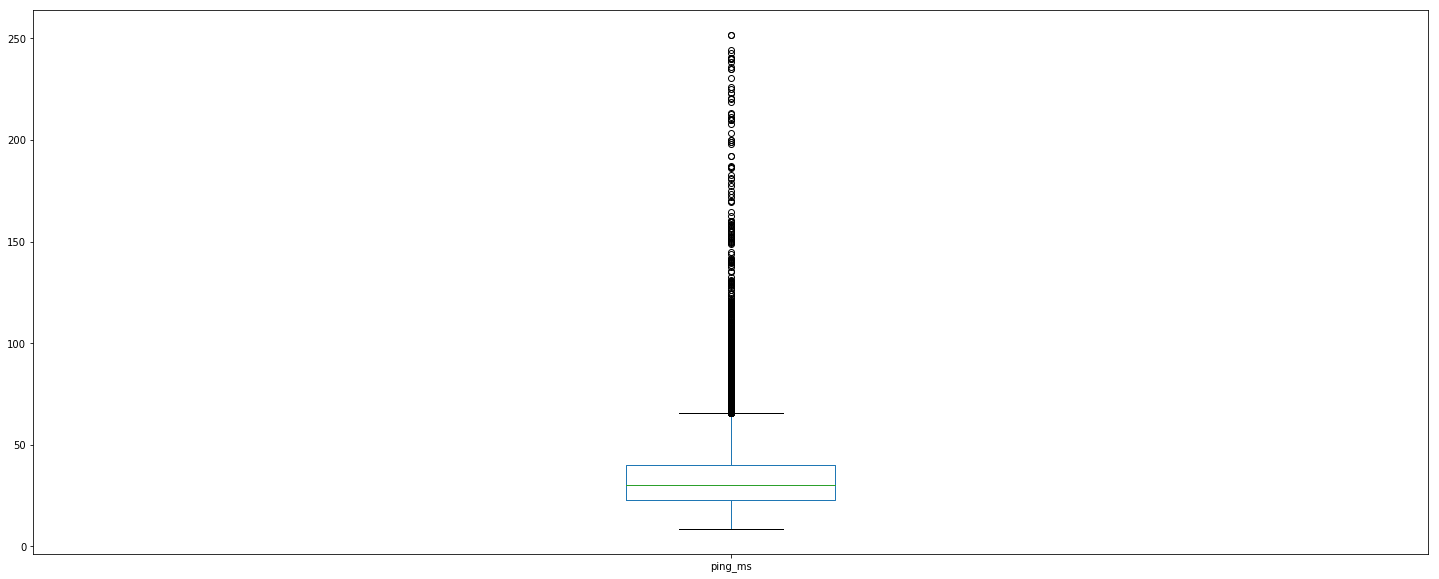

In [8]:
y.hist(bins=100)
y.filter(like='kbit').plot.box()
y.filter(like='ping').plot.box()
y.describe()

# Testing for significance

In [10]:
def mean_pairwise_distance(X):
    return pdist(X).mean()

def p_value(score, scores):
    return percentileofscore(scores, score, kind='weak') / 100

def ttest(X, key, y, n_repeats=1000, n_jobs=1):
    assert len(X.columns & key) == len(key)
    cache = {}
    parallel = Parallel(n_jobs=n_jobs, backend='threading')
    pvals, index = [], []
    for key_value, ids in X.groupby(list(key)).groups.items():
        
        # round to order of magnitude for more cache hits
        n = round(len(ids), -int(np.log10(len(ids))))
        
        if n < 20:
            continue
            
        distances = cache.get(n)
        if distances is None:
            print(n, end='.')
            cache[n] = distances = np.sort(
                parallel(delayed(mean_pairwise_distance)(y.sample(n).values)
                         for _ in range(n_repeats)))
        else:
            print('.', end='')
                
        sample_distance = mean_pairwise_distance(y.loc[ids])
        pval = p_value(sample_distance, distances)
        
        pvals.append(pval)
        index.append(key_value)
    
    print()
    index = (index if len(key) == 1 else
             pd.MultiIndex.from_tuples(index, names=key))
    res = pd.Series(pvals, index=index, name='p_value').round(3)
    res.sort_index(inplace=True)
    res.sort_values(inplace=True)
    return res

In [11]:
%%time
model_pvals = ttest(X, ['model'], y, n_jobs=-1)

50..80.60.100..40.300.500.70.200..2000......3000............700..600.....1000...90......400.......900...30................................800..
CPU times: user 1min 28s, sys: 24.7 s, total: 1min 53s
Wall time: 35.1 s


In [12]:
model_pvals

Acer Iconia Tab 7 (A1-713HD)    0.000
Galaxy S5 Mini (SM-G800F)       0.000
HTC One                         0.000
HUAWEI RIO-L01                  0.000
HUAWEI VNS-L31                  0.000
Huawei P8lite ALE-L04           0.000
Huawei P9 Lite (VNS-L21)        0.000
Moto G (5) Plus                 0.000
                                ...  
SM-G955F                        0.986
Samsung Note 4 (SM-N910F)       0.990
SM-G950F                        0.992
Galaxy S7 edge                  1.000
Galaxy S7                       1.000
iPhone 6s                       1.000
Samsung S5 LTE-A G901F          1.000
iPhone 7 Plus                   1.000
Name: p_value, Length: 90, dtype: float64

count    90.000
mean      0.229
std       0.355
min       0.000
25%       0.000
50%       0.009
75%       0.396
max       1.000
Name: p_value, dtype: float64

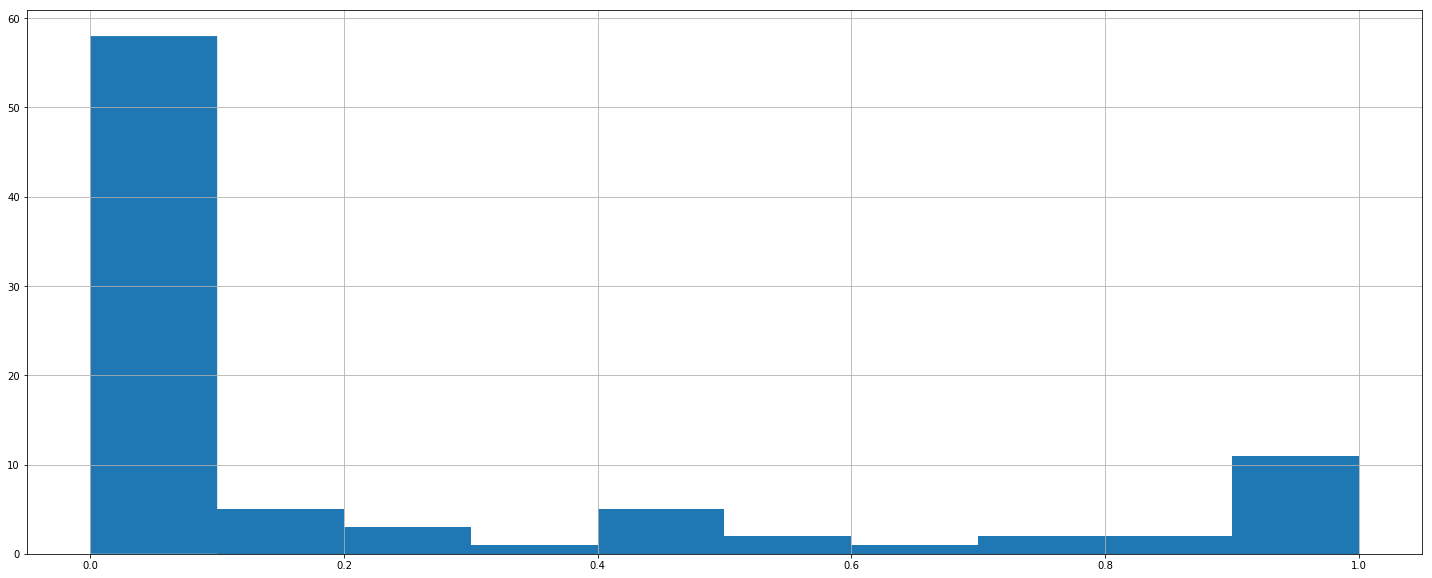

In [27]:
model_pvals.hist()
model_pvals.describe()

In [14]:
%%time
network_type_pvals = ttest(X, ['network_type'], y, n_jobs=5)

100.3000.20000.30.40.600.900.20.
CPU times: user 27min 39s, sys: 9min 27s, total: 37min 6s
Wall time: 8min 49s


In [15]:
network_type_pvals

2G/3G    0.0
2G/4G    0.0
3G/4G    0.0
EDGE     0.0
HSDPA    0.0
HSPA+    0.0
UMTS     0.0
LTE      1.0
Name: p_value, dtype: float64

In [25]:
network_type_pvals.describe()

count    8.000
mean     0.125
std      0.354
min      0.000
25%      0.000
50%      0.000
75%      0.000
max      1.000
Name: p_value, dtype: float64

In [17]:
%%time
sim_mcc_mnc_pvals = ttest(X, ['sim_mcc_mnc'], y, n_jobs=5)

3000.1000.600.4000.30.40.20.50.100.10000.400.800..70...700..500.
CPU times: user 8min 42s, sys: 3min 3s, total: 11min 46s
Wall time: 2min 54s


In [18]:
sim_mcc_mnc_pvals

208-20    0.000
262-03    0.000
262-02    0.000
257-04    0.000
250-99    0.000
250-20    0.000
262-07    0.000
232-12    0.000
          ...  
232-05    0.025
262-01    0.085
232-13    0.306
228-01    0.309
232-11    0.672
232-01    0.906
232-17    1.000
232-03    1.000
Name: p_value, Length: 19, dtype: float64

count    19.000
mean      0.226
std       0.372
min       0.000
25%       0.000
50%       0.000
75%       0.307
max       1.000
Name: p_value, dtype: float64

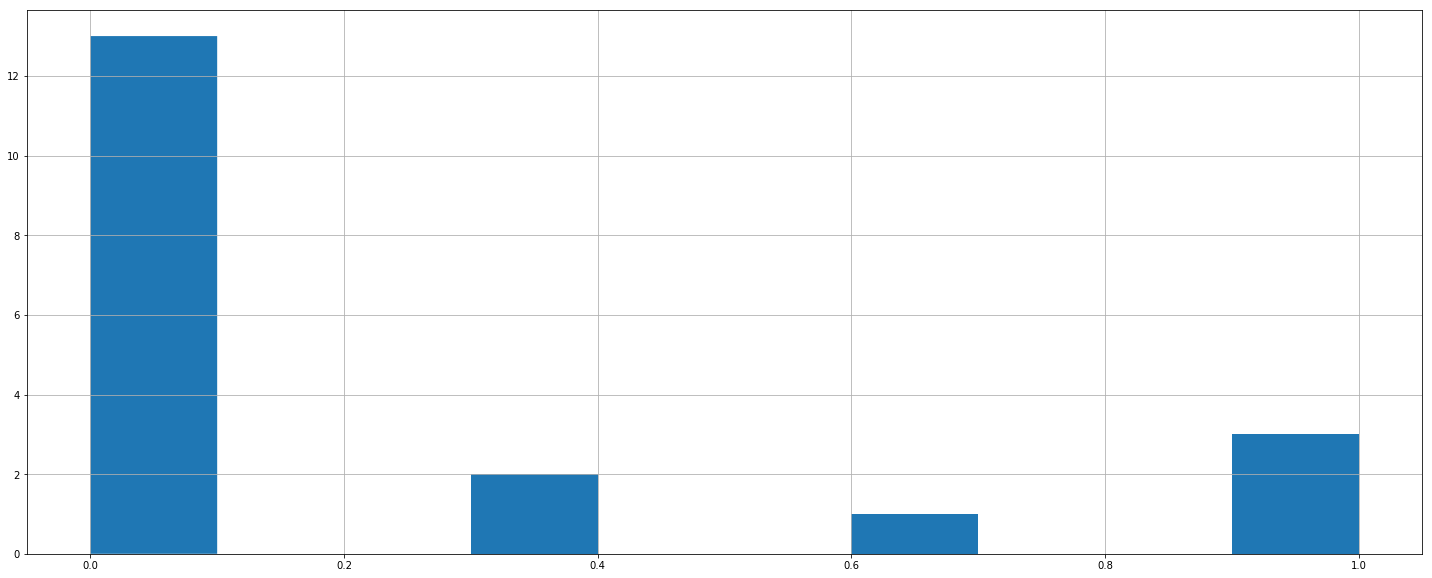

In [28]:
sim_mcc_mnc_pvals.hist()
sim_mcc_mnc_pvals.describe()

In [20]:
%%time
model_network_type_pvals = ttest(X, ['model', 'network_type'], y, n_jobs=-1)

100..60.30..80.400.50....600..200....90..500.......40.20..300............70................................1000..800..................2000..............................3000......700.......................
CPU times: user 1min 17s, sys: 22 s, total: 1min 39s
Wall time: 31.4 s


In [21]:
model_network_type_pvals

model                         network_type
Acer Iconia Tab 7 (A1-713HD)  HSPA+           0.000
Samsung S6 edge (SM-G925F)    HSPA+           0.000
Samsung S6                    HSPA+           0.000
Samsung S5 Neo (SM-G903F)     HSPA+           0.000
Samsung S5 LTE-A G901F        HSPA+           0.000
Samsung S3 Neo (I9301I)       HSPA+           0.000
Samsung Note 4 (SM-N910F)     HSPA+           0.000
Samsung A3 (SM-A300FU)        HSPA+           0.000
                                              ...  
iPad Air Cellular             LTE             0.995
iPhone 7                      LTE             0.995
SM-G955F                      LTE             0.997
iPhone 6s                     LTE             1.000
Galaxy S7 edge                LTE             1.000
Galaxy S7                     LTE             1.000
iPhone 7 Plus                 LTE             1.000
Samsung Note 4 (SM-N910F)     LTE             1.000
Name: p_value, Length: 152, dtype: float64

count    152.000
mean       0.172
std        0.314
min        0.000
25%        0.000
50%        0.000
75%        0.169
max        1.000
Name: p_value, dtype: float64

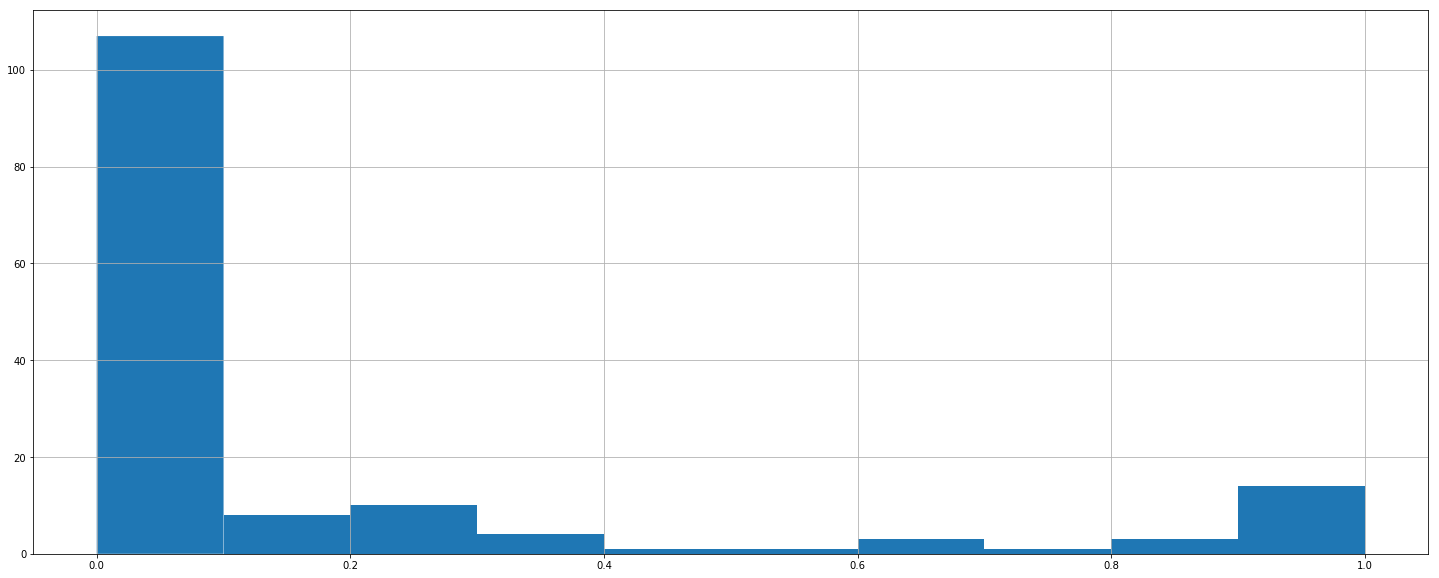

In [29]:
model_network_type_pvals.hist()
model_network_type_pvals.describe()

In [ ]:
...